In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-stats/all_events_stats.xlsx
/kaggle/input/mikyla-xg/Mikyla_xG.png
/kaggle/input/input-data/Rotman MMA Summer Datathon NWHL.csv
/kaggle/input/mikyla-xg-labelled/Mikyla_xG_Labelled.png


In [2]:
nwhl_df = pd.read_csv("../input/input-data/Rotman MMA Summer Datathon NWHL.csv")
nwhl_df.head()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2021-01-23,Minnesota Whitecaps,Boston Pride,1,20:00,5,5,0,0,Boston Pride,...,Faceoff Win,100,43,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:58,5,5,0,0,Boston Pride,...,Puck Recovery,107,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:57,5,5,0,0,Boston Pride,...,Zone Entry,125,28,Carried,NaN,NaN,NaN,Maddie Rowe,NaN,NaN
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:55,5,5,0,0,Boston Pride,...,Shot,131,28,Snapshot,On Net,t,f,NaN,NaN,NaN
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:53,5,5,0,0,Boston Pride,...,Faceoff Win,169,21,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN


In [3]:
import math

xG=[]
for index,row in nwhl_df.iterrows():
    if row['Event']=='Shot' or row['Event']=='Goal':
        if row['Detail 2'] !='Blocked':
            dist=math.sqrt(((200-row['X Coordinate'])**2)+((42.5-row['Y Coordinate'])**2))
            slope = math.tan((42.5-row['Y Coordinate'])/(200-row['X Coordinate']))
            if row['Event']=='Goal':
                xG.append([row['Player'],row['Event'],row['X Coordinate'],row['Y Coordinate'], dist, slope, row['Detail 1'],row['Detail 2'], row['Period'], row['Home Team Skaters'], row['Away Team Skaters'], 1])
            if row['Event']=='Shot':
                xG.append([row['Player'],row['Event'],row['X Coordinate'],row['Y Coordinate'], dist, slope, row['Detail 1'],row['Detail 2'], row['Period'], row['Home Team Skaters'], row['Away Team Skaters'], 0])

xG_df=pd.DataFrame(xG,columns=['Name','Event','X','Y','Distance','Slope','Type','Detail','Period', 'Home Team Skaters', 'Away Team Skaters', 'Result'])
xG_df.head()

,Name,Event,X,Y,Distance,Slope,Type,Detail,Period,Home Team Skaters,Away Team Skaters,Result
0,McKenna Brand,Shot,131,28,70.507092,0.213294,Snapshot,On Net,1,5,5,0
1,Allie Thunstrom,Shot,162,2,55.536024,1.808902,Snapshot,On Net,1,5,5,0
2,Nina Rodgers,Shot,167,18,41.100487,0.917545,Snapshot,Missed,1,5,5,0
3,McKenna Brand,Shot,175,68,35.710643,-1.628130,Snapshot,On Net,1,5,5,0
4,Lauren Kelly,Shot,196,20,22.852790,-0.773201,Snapshot,On Net,1,5,5,0


In [4]:
# Splitting

x_train = xG_df[['Distance', 'Slope', 'Type', 'Detail', 'Period', 'Home Team Skaters', 'Away Team Skaters']]
y_train = xG_df[['Result']]

x_test = xG_df[['Distance', 'Slope', 'Type', 'Detail', 'Period', 'Home Team Skaters', 'Away Team Skaters']]
y_test = xG_df[['Result']]

In [5]:
# Encoding
pd.options.mode.chained_assignment = None

x_train['Type'] = x_train['Type'].astype('category')
x_train['Type'] = x_train['Type'].cat.codes
x_test['Type'] = x_test['Type'].astype('category')
x_test['Type'] = x_test['Type'].cat.codes

x_train['Detail'] = x_train['Detail'].astype('category')
x_train['Detail'] = x_train['Detail'].cat.codes
x_test['Detail'] = x_test['Detail'].astype('category')
x_test['Detail'] = x_test['Detail'].cat.codes

In [6]:
x_train.head()

,Distance,Slope,Type,Detail,Period,Home Team Skaters,Away Team Skaters
0,70.507092,0.213294,3,1,1,5,5
1,55.536024,1.808902,3,1,1,5,5
2,41.100487,0.917545,3,0,1,5,5
3,35.710643,-1.628130,3,1,1,5,5
4,22.852790,-0.773201,3,1,1,5,5


In [7]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [8]:
## Handling Imbalanced Data using SMOTE
print("Shape of training data before SMOTE: {} and {}".format(x_train.shape, y_train.shape))

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
print("Shape of training data after synthetic oversampling: {} and {} ".format(x_train_res.shape, y_train_res.shape))

Shape of training data before SMOTE: (1420, 7) and (1420, 1)
Shape of training data after synthetic oversampling: (2688, 7) and (2688, 1) 


In [9]:
## Shape of training data after synthetic oversampling
print("Value counts before synthetic minority oversampling:\n", y_train.value_counts())
print("\n")
print("Value counts after synthetic minority oversampling:\n", y_train_res.value_counts())

Value counts before synthetic minority oversampling:
 Result
0         1344
1           76
dtype: int64


Value counts after synthetic minority oversampling:
 Result
0         1344
1         1344
dtype: int64


**SMOTE is Synthetic Minority Oversampling Technique - overcoming the overfitting problem and class imbalance problem by generating synthetic minority records by random over-sampling**

## Baseline Models

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve, auc, average_precision_score

from sklearn.model_selection import cross_val_score

In [11]:
models_array = []

## Adding it in an array so that could be made into a dataframe later
models_array.append(['Logistic Regression', LogisticRegression(random_state = 0)])
models_array.append(['K Nearest Neighbours', KNeighborsClassifier()])
#models_array.append(['SVM Classifier', SVC(random_state=0)])
models_array.append(['Gaussian Naive Bayes', GaussianNB()])
models_array.append(['Bernoulli Naive Bayes', BernoulliNB()])
models_array.append(['Decision Tree Classifier', DecisionTreeClassifier(random_state = 0)])
models_array.append(['Random Forest', RandomForestClassifier(random_state = 0)])
models_array.append(['XGBoost Classifier', XGBClassifier(eval_metric = 'error',use_label_encoder=False)])

In [12]:
list1= []

for m in range(len(models_array)):
    list2 = []
    model = models_array[m][1]
    model.fit(x_train_res, y_train_res.values.ravel())
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # training accuracies - K-fold cross validation
    accuracies = cross_val_score(estimator = model, X = x_train_res, y = y_train_res.values.ravel(), cv = 10)
    
    # Accuracy score of test set
    accuracy = accuracy_score(y_test, y_pred)
    
    # Area Score under Reciever Operating Characteristic Curve
    roc = roc_auc_score(y_test, y_pred) 
    
    # Precision
    precision = precision_score(y_test, y_pred)
    
    # Recall
    recall = recall_score(y_test, y_pred)
    
    # F1-score
    f1 = f1_score(y_test, y_pred)
    
    # Printing the results for every model
    print("----------------------------------------")
    print(models_array[m][0], ":")
    print("Training set mean accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Training set standard deviation: {:.2f} %".format(accuracies.std()*100))
    print("Test set accuracy: {:.2f} %".format(accuracy*100))
    print("Confusion Matrix: ", cm)
    print("Precision: {:.2f} %".format(precision*100))
    print("Recall: {:.2f} %".format(recall*100))
    print("F1 score: {:.2f}".format(f1))
    print("AUROC score: {:.2f}".format(roc))
    print("-----------------------------------------")
    print("\n")
    
    ## Adding all scores to a list so that we can form a dataframe later
    list2.append(models_array[m][0])
    list2.append(accuracies.mean()*100)
    list2.append(accuracies.std()*100)
    list2.append(accuracy)
    list2.append(precision)
    list2.append(recall)
    list2.append(f1)
    list2.append(roc)
    
    list1.append(list2)

----------------------------------------
Logistic Regression :
Training set mean accuracy: 74.37 %
Training set standard deviation: 3.08 %
Test set accuracy: 64.93 %
Confusion Matrix:  [[861 483]
 [ 15  61]]
Precision: 11.21 %
Recall: 80.26 %
F1 score: 0.20
AUROC score: 0.72
-----------------------------------------


----------------------------------------
K Nearest Neighbours :
Training set mean accuracy: 86.91 %
Training set standard deviation: 2.09 %
Test set accuracy: 87.89 %
Confusion Matrix:  [[1174  170]
 [   2   74]]
Precision: 30.33 %
Recall: 97.37 %
F1 score: 0.46
AUROC score: 0.92
-----------------------------------------


----------------------------------------
Gaussian Naive Bayes :
Training set mean accuracy: 68.42 %
Training set standard deviation: 2.22 %
Test set accuracy: 40.99 %
Confusion Matrix:  [[508 836]
 [  2  74]]
Precision: 8.13 %
Recall: 97.37 %
F1 score: 0.15
AUROC score: 0.68
-----------------------------------------


-----------------------------------

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


----------------------------------------
XGBoost Classifier :
Training set mean accuracy: 91.63 %
Training set standard deviation: 3.60 %
Test set accuracy: 98.80 %
Confusion Matrix:  [[1328   16]
 [   1   75]]
Precision: 82.42 %
Recall: 98.68 %
F1 score: 0.90
AUROC score: 0.99
-----------------------------------------




In [13]:
y_prob

array([[9.6933877e-01, 3.0661222e-02],
       [9.9770653e-01, 2.2934710e-03],
       [9.9997091e-01, 2.9080253e-05],
       ...,
       [8.3032894e-01, 1.6967106e-01],
       [9.9901420e-01, 9.8581857e-04],
       [9.9987572e-01, 1.2428460e-04]], dtype=float32)

In [14]:
xG_df['Predicted Result'] = y_pred
xG_df['xG%'] = y_prob[:,1]

In [15]:
xG_df.head(10)

,Name,Event,X,Y,Distance,Slope,Type,Detail,Period,Home Team Skaters,Away Team Skaters,Result,Predicted Result,xG%
0,McKenna Brand,Shot,131,28,70.507092,0.213294,Snapshot,On Net,1,5,5,0,0,0.030661
1,Allie Thunstrom,Shot,162,2,55.536024,1.808902,Snapshot,On Net,1,5,5,0,0,0.002293
2,Nina Rodgers,Shot,167,18,41.100487,0.917545,Snapshot,Missed,1,5,5,0,0,0.000029
3,McKenna Brand,Shot,175,68,35.710643,-1.628130,Snapshot,On Net,1,5,5,0,0,0.004584
4,Lauren Kelly,Shot,196,20,22.852790,-0.773201,Snapshot,On Net,1,5,5,0,0,0.114956
5,Haylea Schmid,Shot,181,43,19.006578,-0.026322,Snapshot,On Net,1,5,5,0,0,0.432372
6,Lauren Kelly,Shot,163,10,49.246827,1.205677,Snapshot,On Net,1,5,5,0,0,0.000695
7,Samantha Davis,Shot,188,49,13.647344,-0.601697,Wrap Around,On Net,1,5,5,0,0,0.005012
8,Jillian Dempsey,Shot,149,19,56.153807,0.496426,Snapshot,On Net,1,5,5,0,0,0.079926
9,Jonna Curtis,Shot,167,67,41.100487,-0.917545,Snapshot,On Net,1,5,5,0,0,0.034013


In [16]:
xG_df[xG_df['Event']=='Goal']

,Name,Event,X,Y,Distance,Slope,Type,Detail,Period,Home Team Skaters,Away Team Skaters,Result,Predicted Result,xG%
20,Christina Putigna,Goal,175,44,25.044960,-0.060072,Snapshot,On Net,1,5,5,1,1,0.960160
25,Jonna Curtis,Goal,180,39,20.303941,0.176809,Snapshot,On Net,1,5,5,1,1,0.967954
53,Winny Brodt-Brown,Goal,188,55,17.327723,-1.710137,Snapshot,On Net,2,5,5,1,1,0.707809
123,Kayla Friesen,Goal,144,15,62.387899,0.534765,Snapshot,On Net,2,5,5,1,1,0.875946
159,Kristin Lewicki,Goal,168,28,35.131894,0.486915,Wristshot,On Net,3,5,4,1,1,0.697352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,Kristin Lewicki,Goal,171,55,31.579265,-0.459874,Snapshot,On Net,2,5,5,1,1,0.979766
1384,Meaghan Rickard,Goal,167,55,35.288100,-0.398008,Snapshot,On Net,2,5,5,1,1,0.963046
1392,Lexie Laing,Goal,183,37,17.867568,0.335311,Wristshot,On Net,3,5,4,1,1,0.937147
1402,Mallory Souliotis,Goal,145,37,55.274316,0.100335,Wristshot,On Net,3,4,5,1,1,0.700390


In [17]:
xG_df.to_csv('Expected_Goal_Percentage.csv')

## Visualization of Expected Goals of a specific player (Mikyla) using the above dataset and Tableau

Goals and Shots with Expected Goal Distribution for Mikyla: 

Goals are Circles, Shots are Crosses
The gradient from green to grey to red represent decreasing xG value


AxesImage(100,100;620x604)


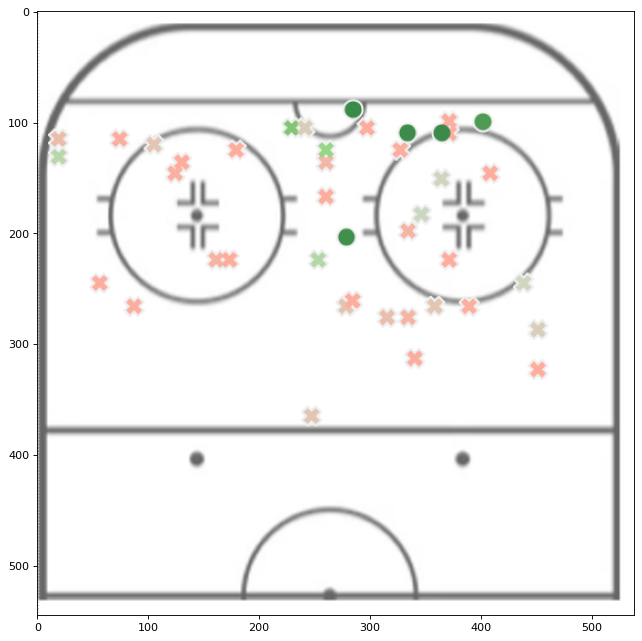

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('../input/mikyla-xg/Mikyla_xG.png')
  
# Output Images
fig = plt.figure(figsize=(10, 10), dpi=80)
print("Goals and Shots with Expected Goal Distribution for Mikyla: ")
print("\nGoals are Circles, Shots are Crosses")
print("The gradient from green to grey to red represent decreasing xG value\n\n")
print(plt.imshow(img))

Labelled Goals and Shots with Expected Goal Distribution for Mikyla: 


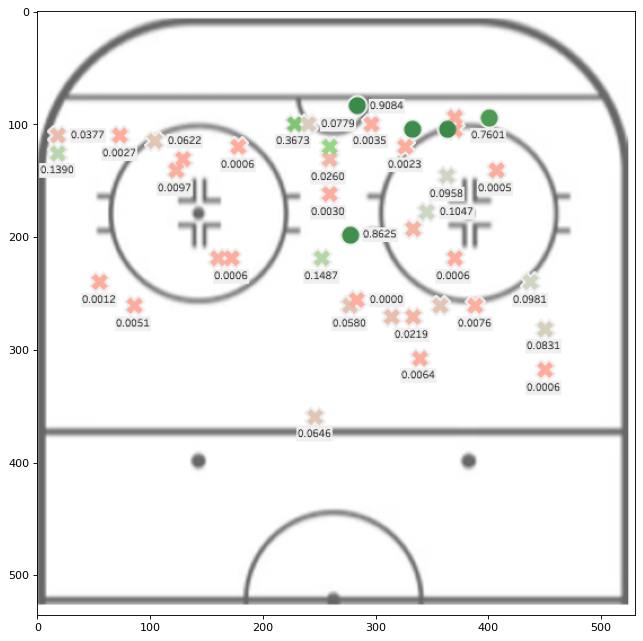

In [19]:
img_labelled = mpimg.imread('../input/mikyla-xg-labelled/Mikyla_xG_Labelled.png')
  
# Output Images
fig = plt.figure(figsize=(10, 10), dpi=80)
print("Labelled Goals and Shots with Expected Goal Distribution for Mikyla: ")
plt.imshow(img_labelled)

## PCA to cluster player styles

In [20]:
pip install openpyxl

     |████████████████████████████████| 243 kB 1.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import numpy as np

all_player_stats = pd.read_excel("../input/all-stats/all_events_stats.xlsx", engine='openpyxl')

In [22]:
all_player_stats.head(10)

,Player,Team.x,Number_of_Games,Total_Goals,Total_Shots,Time_on_Ice,Goals_per_Game,Points_per_60,Shooting_Percentage,Weighted_Goal_Avg,...,Total_Pucks_Recovered,Avg_Pucks_Recovered_per_Game,Total_Dumps_Retained,Total_Dumps_Lost,Avg_Successful_Dumps_per_Game,Avg_Reatined_Dumps_per_Total_Dumps,Weighted_Dump_InOut_Avg,Total_Penalty_Taken,Avg_Penalty_Taken_per_Game,Final_Score
0,Kaleigh Fratkin,Boston Pride,7,0,36,420,0.000000,0.000000,0.000000,0.000000,...,233,33.285714,7,34,1.000000,0.170732,0.585366,5,0.714286,74.028567
1,Shiann Darkangelo,Toronto Six,6,0,36,380,0.000000,0.000000,0.000000,0.000000,...,141,23.500000,4,21,0.666667,0.160000,0.413333,5,0.833333,72.623011
2,Sydney Baldwin,Minnesota Whitecaps,4,1,32,260,0.250000,0.003846,0.030303,0.017075,...,126,31.500000,4,19,1.000000,0.173913,0.586957,2,0.500000,68.316758
3,Kiira Dosdall,Metropolitan Riveters,3,0,17,180,0.000000,0.000000,0.000000,0.000000,...,88,29.333333,3,13,1.000000,0.187500,0.593750,0,0.000000,67.655083
4,Taylor Woods,Toronto Six,6,4,42,380,0.666667,0.010526,0.086957,0.048741,...,175,29.166667,2,29,0.333333,0.064516,0.198925,5,0.833333,63.236473
5,Tori Howran,Connecticut Whale,3,1,13,200,0.333333,0.005000,0.071429,0.038214,...,90,30.000000,1,15,0.333333,0.062500,0.197917,0,0.000000,62.953244
6,Shannon Doyle,Connecticut Whale,4,0,19,260,0.000000,0.000000,0.000000,0.000000,...,125,31.250000,1,22,0.250000,0.043478,0.146739,0,0.000000,62.523321
7,Mallory Souliotis,Boston Pride,7,3,32,420,0.428571,0.007143,0.085714,0.046429,...,196,28.000000,3,24,0.428571,0.111111,0.269841,0,0.000000,59.752660
8,Maggie LaGue,Connecticut Whale,4,0,22,260,0.000000,0.000000,0.000000,0.000000,...,108,27.000000,2,12,0.500000,0.142857,0.321429,0,0.000000,57.245671
9,Lindsay Eastwood,Toronto Six,6,1,36,380,0.166667,0.002632,0.027027,0.014829,...,152,25.333333,4,20,0.666667,0.166667,0.416667,2,0.333333,56.294810


In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
all_player_stats_x = all_player_stats.loc[:, all_player_stats.columns != 'Player']
all_player_stats_x = all_player_stats_x.loc[:, all_player_stats_x.columns != 'Team.x']
all_player_stats_x = all_player_stats_x.loc[:, all_player_stats_x.columns != 'Team.y']
labels = all_player_stats[['Player']]

all_player_stats_x = sc.fit_transform(all_player_stats_x)
all_player_stats_x

array([[ 1.52656362, -0.61258459,  1.74001863, ...,  2.78648471,
         1.51321889,  2.47788415],
       [ 0.92921264, -0.61258459,  1.74001863, ...,  2.78648471,
         1.90089238,  2.39165147],
       [-0.26548932,  0.40301618,  1.4061894 , ...,  0.61921882,
         0.81540659,  2.12745735],
       ...,
       [-0.26548932, -0.61258459, -1.09752983, ..., -0.8256251 ,
        -0.8128221 , -1.76477552],
       [-0.86284031, -0.61258459, -1.09752983, ..., -0.10320314,
         0.27266369, -1.79508598],
       [-2.05754227, -0.61258459, -1.26444445, ..., -0.8256251 ,
        -0.8128221 , -1.87980917]])

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(all_player_stats_x)
pca_df = pd.DataFrame(data = principalComponents
                      ,columns = ['pc1', 'pc2', 'pc3'])

pca_df = pd.concat([labels,pca_df],axis=1)

pca_df = pca_df.sort_values(by='pc1',ascending=True).reset_index()

pca_df.head(5)

,index,Player,pc1,pc2,pc3
0,125,Caty Flagg,-7.497432,-0.258874,1.267551
1,121,Mariah Fujimagari,-7.185703,-0.094595,0.965627
2,118,Abbie Ives,-6.478905,0.115407,0.511735
3,110,Sonjia Shelly,-6.441003,0.398263,0.669890
4,124,Rose Alleva,-6.296405,0.363298,1.532095


In [33]:
from sklearn.cluster import KMeans,DBSCAN
import matplotlib.pyplot as plt
import plotly.express as px
import random

# i like better to be positive
# if (pca_df.loc[pca_df['label']=='2011_Aaron Rodgers'].pc1.values[0] <1):
#     pca_df['pc1'] = pca_df['pc1'] * -1

X = pca_df[['pc1','pc2']].values

x = pca_df.pc1.values
y = pca_df.pc2.values
n = pca_df.Player.values

# clusters = DBSCAN(eps=0.6, min_samples=5).fit_predict(X)
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
clusters = kmeans.predict(X)
print(clusters.shape)
pca_df['cluster'] = clusters

print(X.shape)

fig = px.scatter(pca_df, x=pca_df['pc1'], y=pca_df['pc2'], color=pca_df['cluster'], hover_data=['Player'])
#plt.scatter(X[:, 0], X[:, 1], color=clusters, s=50, cmap='viridis')

# for i, txt in enumerate(n):
#     if ((x[i] >= 4) | (x[i] <=-4)):
#         ax.annotate(txt, (x[i], y[i]))
#     elif ((y[i] >= 3.5) | (y[i] <= -3.5)):
#         ax.annotate(txt, (x[i], y[i]))
#     # label some randoms in the middle
#     elif ((x[i] <= 4) & (x[i] >=-4) & (y[i] <= 3.5) & (y[i] >= -3.5)):
#         if random.random() < 0.15:
#             ax.annotate(txt, (x[i], y[i]))
        
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

fig.update_layout(
    height=1000,
    title_text='2D PCA Viz of Players With  Six Clusters'
)

#fig.savefig('./plots/QB_2D.png', bbox_inches='tight')
fig.show()

(126,)
(126, 2)


In [28]:
pca_df

,index,Player,pc1,pc2,pc3,cluster
0,125,Caty Flagg,-7.497432,-0.258874,1.267551,3
1,121,Mariah Fujimagari,-7.185703,-0.094595,0.965627,3
2,118,Abbie Ives,-6.478905,0.115407,0.511735,3
3,110,Sonjia Shelly,-6.441003,0.398263,0.669890,3
4,124,Rose Alleva,-6.296405,0.363298,1.532095,3
...,...,...,...,...,...,...
121,11,Tereza Vanisova,7.773840,-1.412373,4.697693,1
122,30,McKenna Brand,8.158466,-1.836384,0.786078,1
123,23,Jonna Curtis,8.314185,-2.545868,8.407323,1
124,0,Kaleigh Fratkin,9.035622,7.090271,-1.474714,2


In [29]:
pca_df.to_csv('PCA_all_mertrics.csv')